# Module 2 Final Project Specifications

## Introduction

In this lesson, we'll review all the guidelines and specifications for the final project for Module 2. 

## Objectives

* Understand all required aspects of the Final Project for Module 2
* Understand all required deliverables
* Understand what constitutes a successful project

### Final Project Summary

Another module down--you're half way there!

<img src='halfway-there.gif'>

For the culmination of Module 2, you just need to complete the final project!

### The Project

For this project, you'll be working with the Northwind database--a free, open-source dataset created by Microsoft containing data from a fictional company. You probably remember the Northwind database from our section on Advanced SQL. Here's the schema for the Northwind database:

<img src='Northwind_ERD.png'>

The goal of this project is to test your ability to gather information from a real-world database and use your knowledge of statistical analysis and hypothesis testing to generate analytical insights that can be of value to the company. 

## The Deliverables

The goal of your project is to query the database to get the data needed to perform a statistical analysis.  In this statistical analysis, you'll need to perform a hypothesis test (or perhaps several) to answer the following question:

**_Do discounts have a statistically significant effect on the number of products customers order? If so, at what level(s) of discount?_**

In addition to answering this question with a hypothesis test, you will also need to come up with **_at least 3 other hypotheses to test on your own_**.  These can by anything that you think could be imporant information for the company. 

For this hypothesis, be sure to specify both the **_null hypothesis_** and the **_alternative hypothesis_** for your question.  You should also specify if this is one-tail or a two-tail test. 

To complete this project, you will need to turn in the following 3 deliverables:

1. A **_Jupyter Notebook_** containing any code you've written for this project. 
2. A **_Blog Post_** explaining your process, methodology, and findings.  
3. An **_"Executive Summary" PowerPoint Presentation_** that explains the hypothesis tests you ran, your findings, and their relevance to company stakeholders.  

### Jupyter Notebook Must-Haves

For this project, your jupyter notebook should meet the following specifications:

**_Organization/Code Cleanliness_**

* The notebook should be well organized, easy to follow, and code is commented where appropriate.  
<br>  
    * Level Up: The notebook contains well-formatted, professional looking markdown cells explaining any substantial code. All functions have docstrings that act as professional-quality documentation.  
<br>      
* The notebook is written to technical audiences with a way to both understand your approach and reproduce your results. The target audience for this deliverable is other data scientists looking to validate your findings.  
<br>    
* Any SQL code written to source data should also be included.  

**_Findings_**

* Your notebook should clearly show how you arrived at your results for each hypothesis test, including how you calculated your p-values.   
<br>
* You should also include any other statistics that you find relevant to your analysis, such as effect size. 

### Blog Post Must-Haves

Your blog post should include everything from how you identified what tables contained the information you need, to how you retrieved it using SQL (and any challenges you ran into while doing so), as well as your methodology and results for your hypothesis tests. 

**_NOTE:_**  This blog post is your way of showcasing the work you've done on this project--chances are it will soon be read by a recruiter or hiring manager! Take the time to make sure that you craft your story well, and clearly explain your process and findings in a way that clearly shows both your technical expertise **_and_** your ability to communicate your results!

### Executive Summary Must-Haves

Your presentation should:

* Contain between 5-10 professional quality slides detailing:
<br>  
    * A high-level overview of your methodology  
    <br>  
    * The results of your hypothesis tests  
    <br>  
    * Any real-world recommendations you would like to make based on your findings (ask yourself--why should the executive team care about what you found? How can your findings help the company?)  
    <br>  
* Take no more than 5 minutes to present  
<br>  
* Avoid technical jargon and explain results in a clear, actionable way for non-technical audiences.  

In [1]:
import pandas as pd
import sqlite3
import numpy as np

import scipy.stats as stat

from __future__ import print_function

#data visualization imports
import matplotlib.pyplot as plt
import seaborn as sns

#for ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

# create a connection to the database
conn = sqlite3.connect('Northwind_small.sqlite', detect_types=sqlite3.PARSE_COLNAMES)
c = conn.cursor()

# query the database
c.execute("SELECT * FROM OrderDetail;")

# store results in a dataframe
orders = pd.DataFrame(c.fetchall())
orders.columns = [i[0] for i in c.description]
orders.head()

,Id,OrderId,ProductId,UnitPrice,Quantity,Discount
0,10248/11,10248,11,14.0,12,0.0
1,10248/42,10248,42,9.8,10,0.0
2,10248/72,10248,72,34.8,5,0.0
3,10249/14,10249,14,18.6,9,0.0
4,10249/51,10249,51,42.4,40,0.0


In [6]:
orders.isna().sum()

Id           0
OrderId      0
ProductId    0
UnitPrice    0
Quantity     0
Discount     0
dtype: int64

In [7]:
orders.describe()

,OrderId,ProductId,UnitPrice,Quantity,Discount
count,2155.000000,2155.000000,2155.000000,2155.000000,2155.000000
mean,10659.375870,40.793039,26.218520,23.812993,0.056167
std,241.378032,22.159019,29.827418,19.022047,0.083450
min,10248.000000,1.000000,2.000000,1.000000,0.000000
25%,10451.000000,22.000000,12.000000,10.000000,0.000000
50%,10657.000000,41.000000,18.400000,20.000000,0.000000
75%,10862.500000,60.000000,32.000000,30.000000,0.100000
max,11077.000000,77.000000,263.500000,130.000000,0.250000


In [8]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 6 columns):
Id           2155 non-null object
OrderId      2155 non-null int64
ProductId    2155 non-null int64
UnitPrice    2155 non-null float64
Quantity     2155 non-null int64
Discount     2155 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 101.1+ KB


/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 0, 'Quantity of Product')

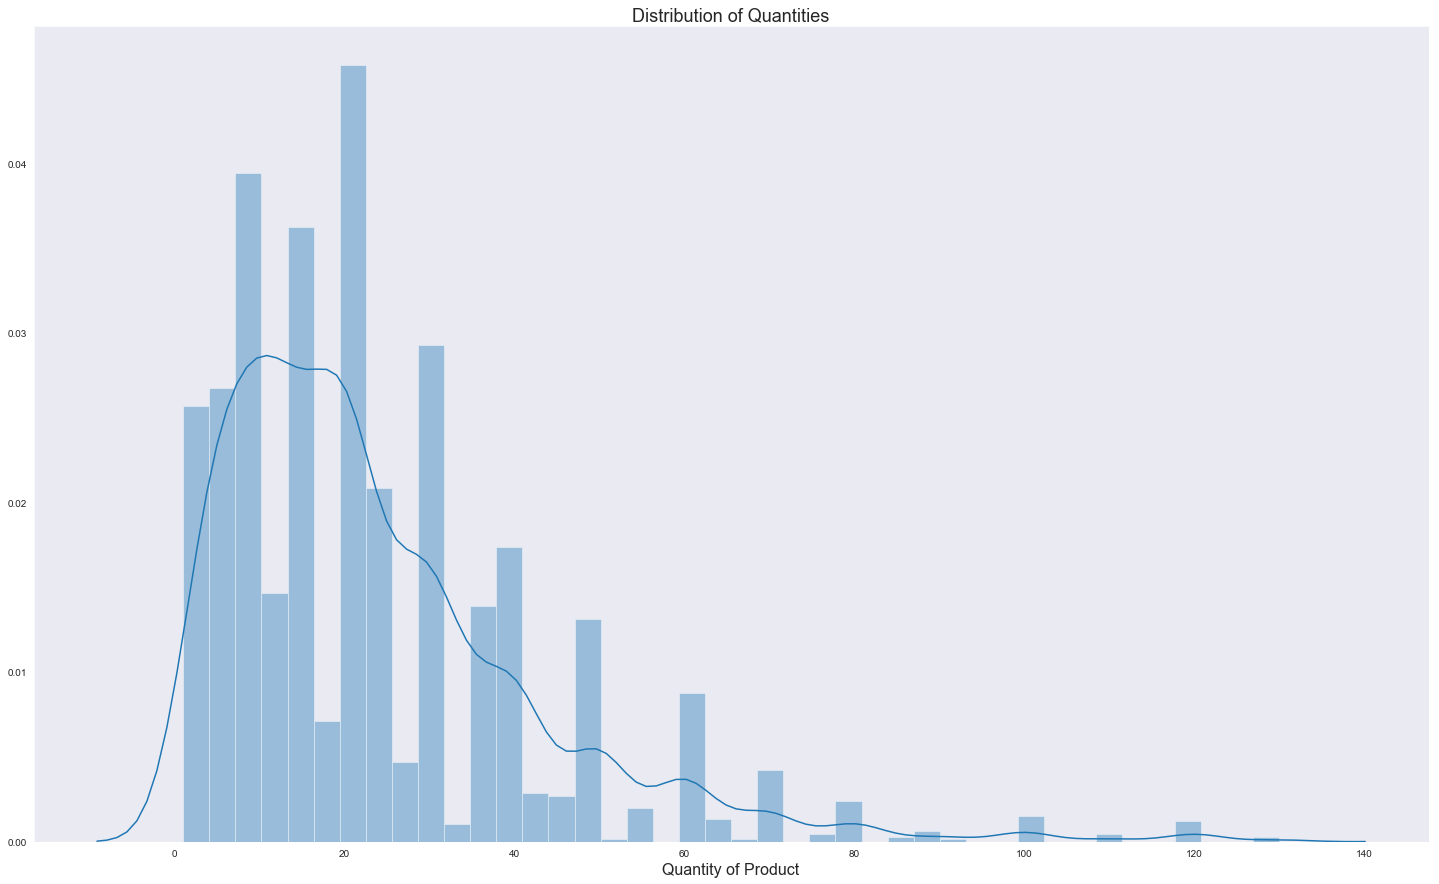

In [9]:
sns.set_style('dark')

plt.figure(figsize=(25, 15))
sns.distplot(orders['Quantity'])
plt.title('Distribution of Quantities', fontsize=18)
plt.xlabel('Quantity of Product', fontsize=16)

In [10]:
# create control and experimental groups
control = orders[orders['Discount'] == 0]
control = control['Quantity']
exp = orders[orders['Discount'] != 0]
exp = exp['Quantity']

In [14]:
print('Normality of distribution: ', stat.normaltest(control))
print('Normality of distribution: ', stat.normaltest(exp))

Normality of distribution:  NormaltestResult(statistic=544.5770045551502, pvalue=5.579637380545965e-119)
Normality of distribution:  NormaltestResult(statistic=261.528012299789, pvalue=1.6214878452829618e-57)


Both the control and experimental group are skewed to the right, therefore they are not "normal".  Therefore, we will be relying on CLT for the hypothesis test.

The Central Limit Theorem (CLT) is a statistical theory states that given a sufficiently large sample size from a population with a finite level of variance, the mean of all samples from the same population will be approximately equal to the mean of the population.

In [16]:
# create function to sample with replacement
def get_sample(df, n):
    sample = []
    while len(sample) != n:
        x = np.random.choice(df)
        sample.append(x)
    return sample

# create function to calculate mean of the sample
def get_sample_mean(sample):
    return sum(sample)/len(sample)

# combine functions to create a sample distribution
# create a distribution size of 1000 and sample size of 500
def create_sample_distribution(df, dist_size=1000, n=500):
    sample_dist = [] 
    while len(sample_dist) != dist_size:
        sample = get_sample(df, n)
        sample_mean = get_sample_mean(sample)
        sample_dist.append(sample_mean)
        
    return sample_dist



In [19]:
# create sample distributions of sample mean for control and experimental
ctrl_sample = create_sample_distribution(control)
exp_sample = create_sample_distribution(exp)

/anaconda3/envs/learn-env/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


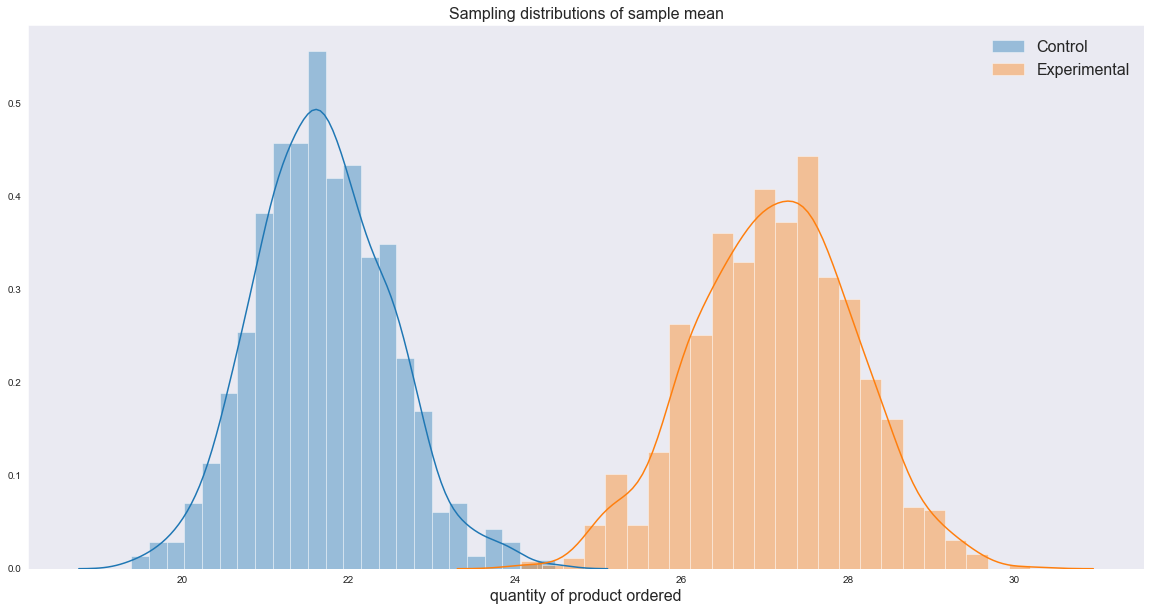

In [20]:
plt.figure(figsize = (20, 10))
sns.distplot(ctrl_sample, label='Control')
sns.distplot(exp_sample, label='Experimental')
plt.title('Sampling distributions of sample mean', fontsize=16)
plt.xlabel('quantity of product ordered', fontsize=16)
plt.legend(frameon=False, fontsize=16, loc='best')

In [21]:
# test whether variances are equal
# if True use Student t-test
# if False use Welch's t-test
np.var(control) == np.var(exp)

False

In [22]:
stat.ttest_ind(exp_sample, ctrl_sample, equal_var=False)

Ttest_indResult(statistic=137.6344349355858, pvalue=0.0)

In [23]:
# function for calculating Cohen's d
def Cohen_d(group1, group2):

    diff = group1.mean()-group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1*var1+n2*var2) / (n1+n2)
  
    d = diff / np.sqrt(pooled_var)
    
    return d

# calculate Cohen's d for target and control samples
print("Cohen's d:" , Cohen_d(np.array(exp_sample), np.array(ctrl_sample)))

Cohen's d: 6.15827896086527


Paramaters I am used to when dealing with Cohen's d<br>
Cohen's d <br>
small effect = 0 to .2 std <br>
med. effect = .2 to .5 std <br>
large effect > .5 std <br>

Learn.co's parameters <br>
small effect = 0 to .2 std <br>
med. effect = .2 to .8 std <br>
large effect > .8 std <br>

either way: 6.15827896086527 > large effect minimum<br>
 **Our results have a large effect size**

In [24]:
orders['Quantity'].groupby(orders['Discount']).describe()

,count,mean,std,min,25%,50%,75%,max
Discount,,,,,,,,
0.00,1317.0,21.715262,17.507493,1.0,10.0,18.0,30.0,130.0
0.01,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.02,2.0,2.000000,1.414214,1.0,1.5,2.0,2.5,3.0
0.03,3.0,1.666667,0.577350,1.0,1.5,2.0,2.0,2.0
0.04,1.0,1.000000,NaN,1.0,1.0,1.0,1.0,1.0
0.05,185.0,28.010811,22.187685,1.0,14.0,20.0,40.0,120.0
0.06,1.0,2.000000,NaN,2.0,2.0,2.0,2.0,2.0
0.10,173.0,25.236994,21.186503,2.0,10.0,20.0,30.0,130.0
0.15,157.0,28.382166,20.923099,2.0,15.0,21.0,40.0,100.0


In [26]:
# wrap with C() to indicate categorical variable
results = ols('Quantity ~ C(Discount)', data=orders).fit()

In [27]:
aov_table = sm.stats.anova_lm(results, typ=2)
print(aov_table)

                    sum_sq      df         F        PR(>F)
C(Discount)   21258.403604    10.0  6.011811  4.704231e-09
Residual     758141.232591  2144.0       NaN           NaN


In [28]:
mc = MultiComparison(orders['Quantity'], orders['Discount'])
mc_results = mc.tukeyhsd()
print(mc_results)

Multiple Comparison of Means - Tukey HSD,FWER=0.05
group1 group2 meandiff  lower    upper  reject
----------------------------------------------
 0.0    0.01  -19.7153 -80.3306 40.9001 False 
 0.0    0.02  -19.7153 -62.593  23.1625 False 
 0.0    0.03  -20.0486 -55.0714 14.9742 False 
 0.0    0.04  -20.7153 -81.3306 39.9001 False 
 0.0    0.05   6.2955   1.5381   11.053  True 
 0.0    0.06  -19.7153 -80.3306 40.9001 False 
 0.0    0.1    3.5217  -1.3783   8.4217 False 
 0.0    0.15   6.6669   1.551   11.7828  True 
 0.0    0.2    5.3096   0.2508  10.3684  True 
 0.0    0.25   6.525    1.3647  11.6852  True 
 0.01   0.02    0.0    -74.2101 74.2101 False 
 0.01   0.03  -0.3333  -70.2993 69.6326 False 
 0.01   0.04    -1.0   -86.6905 84.6905 False 
 0.01   0.05  26.0108  -34.745  86.7667 False 
 0.01   0.06    0.0    -85.6905 85.6905 False 
 0.01   0.1    23.237  -37.5302 84.0042 False 
 0.01   0.15  26.3822  -34.4028 87.1671 False 
 0.01   0.2   25.0248  -35.7554  85.805 False 
 0.01   0

**we can reject the null hypothesis**, there is a statistically significant difference at 5%,15%,20%,25%